# Plot diversity in EOF modes of candidates selection

Step of the codes :
- Import modules 
- Define settings 
- Define functions 
- Download pc p1, pc pred, pc optim and pc obs
- Get candidates emulations
- Download EOF solver
- Download candidates data 
- Project candidates on EOF basis and get pseudo-pcs 
- Plot figure

# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# tqdm + Remove warnings
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Settings

### Variables

In [2]:
variables = ['tas']
var = 'tas'
trunc = 18
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ ($K$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/PPE/CNRM-CM6-1_PPE/'
path_files='/data/scratch/globc/peatier/HOME_files/PPE/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/scratch/globc/peatier/HOME_files/PPE/ENSEMBLE2/files/npy/'

# Functions

In [4]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [5]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [6]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix 
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [7]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

# Get data 

In [8]:
path_file = path_files+'npy/'
filename = 'CNRMppe_decomposition_mean_'+str(var)+'.npy'
Mean =  pd.read_pickle(path_file+filename).to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

In [9]:
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(var)+'.npy')
W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(var)+'.npy')

# Download PCs

In [10]:
## PPE
path = path_files+'nc/'
filename = 'pc_PPE_'+var+'.nc'
pc_PPE = xr.open_mfdataset(path+filename,combine='by_coords')
dims_dict = {'time' : 'members', 'mode' : 'modes'}
pc_PPE = pc_PPE.rename_dims(dims_dict)
    
## observations
path = path_files+'nc/'
filename = 'pc_obs_'+var+'.nc'
pc_obs = xr.open_mfdataset(path+filename,combine='by_coords')
    
## p1 - the first line of pc_PPE
pc_p1 = pc_PPE['pcs'][0,:]
    
## predictions
path = path_files+'nc/'
filename = 'pc_pred_'+var+'.nc'
pc_pred = xr.open_mfdataset(path+filename,combine='by_coords')
pc_pred = pc_pred.rename({'__xarray_dataarray_variable__' : 'pcs'})

## emulated candidates 
path = path_files+'nc/'
filename = 'PC_candidates_'+var+'_uni_kmedian.nc'
pc_cand_emul = xr.open_dataset(path+filename)
pc_cand_emul = pc_cand_emul.rename({'__xarray_dataarray_variable__' : 'pcs'})

In [11]:
path = path_files+'nc/'
filename = 'optim_pc_PPE_'+var+'.nc'
pc_optim = xr.open_mfdataset(path+filename,combine='by_coords')

In [12]:
df_optim = pd.DataFrame()
for i in range(1,trunc+1,1) :
    df_optim['EOF '+str(i)] = pc_optim['EOF '+str(i)].values
df_optim['LHS index'] = pc_optim['LHS index'].values

# Download EOF solver

In [13]:
import pickle
path = path_files+'pkl/'

# open a file, where you stored the pickled data
file = open(path+'solver_'+var+'.pkl', 'rb')

# dump information to that file
solver = pickle.load(file)

# close the file
file.close()

In [14]:
eofs = {}
variances = {}
eofs = solver.eofsAsCovariance(pcscaling=1)
variances = solver.varianceFraction() 

In [15]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = 'tas_*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, ['tas'])

In [16]:
lat = p1_amip['lat']
lon = p1_amip['lon']
eofs_nb = arange(1,104,1)
eofs_xr = {}
eofs_combined = {}

eofs_xr = xr.DataArray(eofs, 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])#.to_dataset(name=var)
## --Combine the modes for reconstruction
eofs_combined = eofs_xr

# Get observation

In [17]:
path_observation = '/data/scratch/globc/peatier/obs/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'
var = 'tas'

In [18]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']
df_obs['tas'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'

In [19]:
obs = {}
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

# Analysis Candidates

In [20]:
nb_p_select = ['p970', 'p971', 'p972', 'p973', 'p974', 
               'p975', 'p976', 'p977', 'p979', 'p980',
                'p981']

In [21]:
## -- CNRM-CM candidates simulations :
path_cand = 'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/ESD_2024_select_k_median/select_tas/'
filename='*_amip_*.nc'
amip_select=[]
for p in tqdm(nb_p_select) :
    path=path_PPE+path_cand+'CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_tas_xarr(path, filename, variables)
    amip_select.append(amip_tmp)

100%|██████████| 11/11 [00:02<00:00,  4.98it/s]


In [22]:
## --Analysis of the candidates  :
U_sel_list = []
X_sel_rec_list = []
p_sel_list = []
e_sel_list = []
for X_sel in tqdm(amip_select) :
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
          
    ## -- Full error RMSE : 
    e_sel = MSE(X_sel, obs[var], W_rmse_2D)
    e_sel_list.append(float(e_sel))
    
    ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=trunc, weighted=False, eofscaling=1)
    U_sel_list.append(U_sel)
    
    ## --Reconstruct the candidates :
    X_sel_rec = reconstruct_X(eofs_combined[0:trunc], pc=U_sel[0:trunc], nb_dims=2)
    X_sel_rec_list.append(X_sel_rec)
    
    ## -- Reconstruct obs :
    pc=pc_obs['pseudo_pcs'][0:trunc]
    X_obs_w = reconstruct_X(eofs_combined[0:trunc], pc, nb_dims=2)
    
    ## -- Parametric errors RMSE_rec : 
    p_sel = MSE_rec(X_sel_rec, X_obs_w, Mean, W_rmse_2D)
    p_sel_list.append(float(p_sel))

100%|██████████| 11/11 [00:01<00:00,  8.95it/s]


In [23]:
## Compute p error for p_emul_cand
p_emul_list = []
pc_obs=pc_obs['pseudo_pcs'][0:trunc]

## --Reconstruct the candidates :
for pc in pc_cand_emul['pcs'][:, 0:trunc] :
    X_emul_sel_rec = reconstruct_X(eofs_combined[0:trunc], pc, nb_dims=2)
    X_obs_w = reconstruct_X(eofs_combined[0:trunc], pc_obs, nb_dims=2)
    p_emul = MSE_rec(X_emul_sel_rec, X_obs_w, Mean, W_rmse_2D)
    #print(float(p_emul))
    p_emul_list.append(float(p_emul))

In [24]:
## Compute p error for ref 
pc = pc_p1[0:trunc]
X_p1_rec = reconstruct_X(eofs_combined[0:trunc], pc, nb_dims=2)
pc_obs=pc_obs[0:trunc]
X_obs_w = reconstruct_X(eofs_combined[0:trunc], pc_obs, nb_dims=2)
p_p1 = MSE_rec(X_p1_rec, X_obs_w, Mean, W_rmse_2D)
print(float(p_p1))

1.052631706505901


In [25]:
## Check p_emul_list
for i in p_emul_list :
    if i<p_p1 :
        print('lower than ref. = '+str(i))
    else :
        print('higher = '+str(i))

lower than ref. = 0.7811872320711972
lower than ref. = 0.7217832688861059
lower than ref. = 0.5798622326206332
lower than ref. = 0.5456012712513759
lower than ref. = 0.8639833639532163
lower than ref. = 0.5740653645227649
lower than ref. = 0.7197180866627495
lower than ref. = 0.8885472840766526
lower than ref. = 0.8813823789445174
lower than ref. = 0.7268996358918531
lower than ref. = 0.9314901647954223
lower than ref. = 0.7091460869356473


In [26]:
## Check p_sel_list
for i in p_sel_list :
    if i<p_p1 :
        print('lower than ref. = '+str(i))
    else :
        print('higher = '+str(i))

lower than ref. = 0.9306805185123898
lower than ref. = 0.6496806562639849
lower than ref. = 0.6175691317406287
lower than ref. = 0.7199537660204988
lower than ref. = 0.9829078048877595
lower than ref. = 0.8392787412820847
lower than ref. = 0.9841680190198248
lower than ref. = 0.8485986898352027
lower than ref. = 0.9542285927155522
lower than ref. = 0.8824245903480447
lower than ref. = 0.8224851238403668


In [27]:
## Check e_sel_list
for i in e_sel_list :
    i=float(sqrt(i))
    if i<1.41 :
        print('lower than ref. = '+str(i))
    else :
        print('higher = '+str(i))

lower than ref. = 1.3843003229686721
lower than ref. = 1.2877085709755138
lower than ref. = 1.2724307384674263
lower than ref. = 1.3161832061538203
lower than ref. = 1.397958506968606
lower than ref. = 1.3615172463351493
higher = 1.4118714417525655
lower than ref. = 1.3436629051639442
lower than ref. = 1.3923826960714762
lower than ref. = 1.3977063561469396
lower than ref. = 1.36503566849094


In [28]:
df_optim.iloc[0]

EOF 1        0.053160
EOF 2        0.591416
EOF 3        0.177104
EOF 4        0.866376
EOF 5       -0.718467
EOF 6       -0.659540
EOF 7       -0.043037
EOF 8        0.556143
EOF 9        0.368302
EOF 10      -1.033655
EOF 11       0.433413
EOF 12       1.109543
EOF 13       0.321662
EOF 14       1.513375
EOF 15       0.452024
EOF 16      -0.274896
EOF 17      -0.594091
EOF 18      -0.293426
LHS index    0.000000
Name: 0, dtype: float64

In [29]:
## Vérifier que toutes les émulations optimales ont une erreure plus basse que la référence 
p_optim = []
for i in tqdm(range(0,len(df_optim), 1)) :
    pc = df_optim.iloc[i][0:trunc]
    X_optim_rec = reconstruct_X(eofs_combined[0:trunc], pc, nb_dims=2)
    pc_obs=pc_obs[0:trunc]
    X_obs_w = reconstruct_X(eofs_combined[0:trunc], pc_obs, nb_dims=2)
    x = MSE_rec(X_optim_rec, X_obs_w, Mean, W_rmse_2D)
    p_optim.append(float(x))
df_optim['p'] = p_optim
df_optim

100%|██████████| 27044/27044 [04:22<00:00, 103.15it/s]


,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,EOF 10,EOF 11,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,EOF 18,LHS index,p
0,0.053160,0.591416,0.177104,0.866376,-0.718467,-0.659540,-0.043037,0.556143,0.368302,-1.033655,0.433413,1.109543,0.321662,1.513375,0.452024,-0.274896,-0.594091,-0.293426,0,1.036283
1,-0.657846,-0.100945,2.477285,-0.208477,0.485037,0.204115,-0.430936,-0.878425,0.267369,-0.884294,0.385899,1.002614,0.633994,1.667335,0.034571,-0.438587,-0.113232,0.295160,4,0.807454
2,-1.469691,-0.875863,1.867064,0.317734,-0.117693,0.040501,0.693874,-0.572920,0.494803,-0.681906,-0.965773,-0.335607,-0.420781,-0.830582,-0.770457,-0.512788,0.183501,0.401789,5,0.971315
3,-0.680900,-1.489689,-0.527394,1.221240,-0.160196,0.208807,-1.040138,0.537645,-1.246971,0.123964,-0.249919,-0.070425,0.553692,0.984405,-0.090978,-0.765706,1.268793,-0.568357,7,0.914362
4,0.272092,-0.762280,1.690819,-1.126358,-0.707616,1.384625,-1.228676,-1.250914,0.390563,1.171336,0.627476,-1.795416,-1.621383,-1.177932,-0.507721,-0.073076,0.019042,0.074648,8,0.922729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27039,-0.098217,0.735165,0.579784,-0.356114,0.113721,0.339570,0.282826,0.587459,0.728209,-0.162594,-0.135067,-0.845899,0.242420,0.680693,-0.674631,-0.947836,-1.431510,0.483259,99988,0.925384
27040,-0.149039,-0.725431,0.610171,-0.045447,0.002070,0.256868,0.127133,1.105932,0.464851,-0.849792,0.272097,0.785348,0.092108,1.290775,1.655337,1.314121,-0.300648,-0.383309,99989,0.751954
27041,0.260802,-0.619722,1.692303,0.659605,-0.656065,-0.420272,1.021974,-0.146405,0.256291,-0.410115,1.157031,0.030987,-1.149404,-0.878397,1.373247,0.333857,0.346994,0.324415,99990,0.948723
27042,0.143116,-0.908388,0.486532,0.129072,0.657171,0.388476,-0.295390,-0.084206,-0.310382,1.312090,-0.336693,-0.187981,-0.483243,0.600137,-1.563443,0.047189,-0.411096,-0.254533,99994,1.013667


In [30]:
for p in tqdm(df_optim['p']) :
    if p>p_p1 :
        print('higher than ref. = '+str(p))

100%|██████████| 27044/27044 [00:00<00:00, 38792.21it/s]


In [31]:
## -- Faire DataFrame des candidats :
df_sel = pd.DataFrame()

for i in tqdm(range(0,18,1)) :
    U_sel_df = []
    for mb in range(0,len(nb_p_select),1) :
        U_sel_df.append(float(U_sel_list[mb][i]))
    
    df_sel['EOF '+str(i+1)] = U_sel_df
    
#df_sel['p'] = p_sel_list
df_sel

100%|██████████| 18/18 [00:00<00:00, 1167.32it/s]


,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,EOF 10,EOF 11,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,EOF 18
0,-0.654848,-1.443328,0.446250,0.915321,0.981299,0.427429,-1.004429,0.058288,0.060800,0.813852,-1.216157,0.945853,0.320825,0.238728,-0.908515,-0.228015,0.050997,-1.241732
1,-0.439338,-0.671463,-0.103887,-0.168686,-1.523956,-0.118120,0.487045,-0.159394,-0.965439,-1.015203,-0.340848,-0.243244,1.363282,0.191840,0.655060,-1.191317,0.548761,-0.059298
2,-1.137770,-0.889979,0.412668,-0.607676,-0.833003,0.555838,-0.175107,1.025299,0.121478,-0.450598,-0.950316,0.663575,-0.713029,-1.311406,0.373047,-0.420226,-0.504975,-0.214887
3,-0.802284,-0.901894,0.818536,-0.318115,-1.517223,-0.806377,0.023068,-0.808524,1.621510,-1.663582,-0.932900,0.054566,0.570481,0.846179,-0.146720,-0.536581,-1.497693,-0.957029
4,-0.374680,-2.243893,1.689583,1.378409,0.228512,1.828899,-1.354046,-0.372838,-0.155780,0.985018,0.330527,1.345726,-1.327052,-1.310833,-0.019013,-0.430334,-1.099575,-2.149230
5,-0.990860,-2.081814,0.829666,0.981919,-1.118110,0.373762,-0.666217,-0.482001,-1.308910,0.565484,-1.121515,1.465783,-0.096056,1.089847,0.338566,-0.516066,1.163266,-0.510982
6,-1.202389,-0.523375,-0.068662,-0.465762,-0.492641,0.801189,-1.467949,-0.426708,0.529241,-1.917151,-1.101160,1.198596,0.640518,-0.681809,-0.232856,2.159721,-0.852695,-0.122145
7,-0.249705,0.034528,0.121303,-0.608909,-0.620926,-0.431580,-0.537785,-1.018427,1.164270,-0.009613,-0.281095,0.639826,-1.096978,-1.153153,-0.607771,-0.648611,0.310096,-0.998310
8,-0.421635,-1.383829,-0.591026,-0.385531,-2.118580,-0.472324,-2.430347,-1.061068,-1.260782,-0.125734,-0.126466,0.499638,1.645141,0.059546,0.137583,0.559062,-2.373862,-1.248080
9,-0.262712,-1.132858,-0.585351,-1.511215,-2.335308,0.245879,-1.191126,-1.756378,-1.025725,0.314592,-0.545663,-0.280967,1.015900,-0.298634,-0.089100,-0.680227,-2.175791,-0.669033


## Figure

### Concatenate everything in a big Data Frame 

In [32]:
Names= []
for i in range(1,trunc+1,1) : 
    tmp = 'EOF '+str(i)
    Names.append(tmp)
#Names.append('p')
#Names

In [33]:
## -- Emulated members
df_pc_pred = pd.DataFrame(pc_pred['pcs'][0:trunc].values.transpose(), columns=Names)
df_fig = df_pc_pred.copy()#.reset_index()
df_fig['Legend'] = ['Emulated members']*len(df_fig)
#df_fig

In [34]:
## -- Members with lower error than reference
df_pc_low = df_optim.drop('LHS index', axis=1)
df_pc_low['Legend'] = ['$p_{tas}(\\theta_i)<p_{tas}(\\theta_0)$']*len(df_pc_low)
df_fig = df_fig.append(df_pc_low)
#df_fig

In [35]:
## -- Emulated candidates

# FIRST we eliminate the emulations that crashed in the runs
pc_cand_emul_not_crashed = []

for i in range(0,8,1) :
    x = pc_cand_emul['pcs'][i,:].values
    pc_cand_emul_not_crashed.append(x)

x = pc_cand_emul['pcs'][9,0:18]
pc_cand_emul_not_crashed.append(x)
x = pc_cand_emul['pcs'][10,0:18]
pc_cand_emul_not_crashed.append(x)
x = pc_cand_emul['pcs'][11,0:18]
pc_cand_emul_not_crashed.append(x)
#len(pc_cand_emul_not_crashed)

# Then we add them to the dataframe 
df_pc_best = pd.DataFrame(pc_cand_emul_not_crashed, columns=Names)

names = []
for i in range(1, len(df_pc_best)+1, 1) :
    tmp = 'Emulated candidate '+str(i)
    names.append(tmp)
df_pc_best['Legend'] = names 
df_fig = df_fig.append(df_pc_best)
#df_fig

In [36]:
## -- CNRM-CM candidates 
names=[]
for i in range(1,len(nb_p_select)+1,1) :
    tmp = 'CNRM-CM candidate '+str(i)
    names.append(tmp)
df_sel['Legend'] = names 
df_fig = df_fig.append(df_sel)

#df_fig

In [37]:
## -- Observations 
U_obs_list = []
Names = []
cpt=1
cols = []
#cols = ['index']
U_obs_tmp = pc_obs#['pseudo_pcs'].values
U_obs = U_obs_tmp[0:trunc]
for i in U_obs :
    U_obs_list.append(float(i))
    tmp = 'EOF '+str(cpt)
    cols.append(tmp)
    Names.append(tmp)
    cpt+=1
df_obs = pd.DataFrame([U_obs_list], columns=Names)
#df_obs['index'] = 0
df_obs['p'] = 0
df_obs['Legend'] = 'BEST observations'
#cols.append('p')
cols.append('Legend')
df_obs_sort = df_obs[cols]
df_fig = df_fig.append(df_obs_sort)
#df_fig

## -- Reference CNRM-CM6-1
U_p1_list = []
U_p1_tmp = pc_p1.values
U_p1 = U_p1_tmp[0:trunc]
for i in U_p1 : 
    U_p1_list.append(float(i))
df_p1 = pd.DataFrame([U_p1_list], columns=Names)
#df_p1['index'] = 0
#df_p1['p'] = p_p1
df_p1['Legend'] = 'CNRM-CM6-1 ref.'
df_p1_sort = df_p1[cols]
df_fig = df_fig.append(df_p1_sort)
#df_fig

<Figure size 432x288 with 0 Axes>

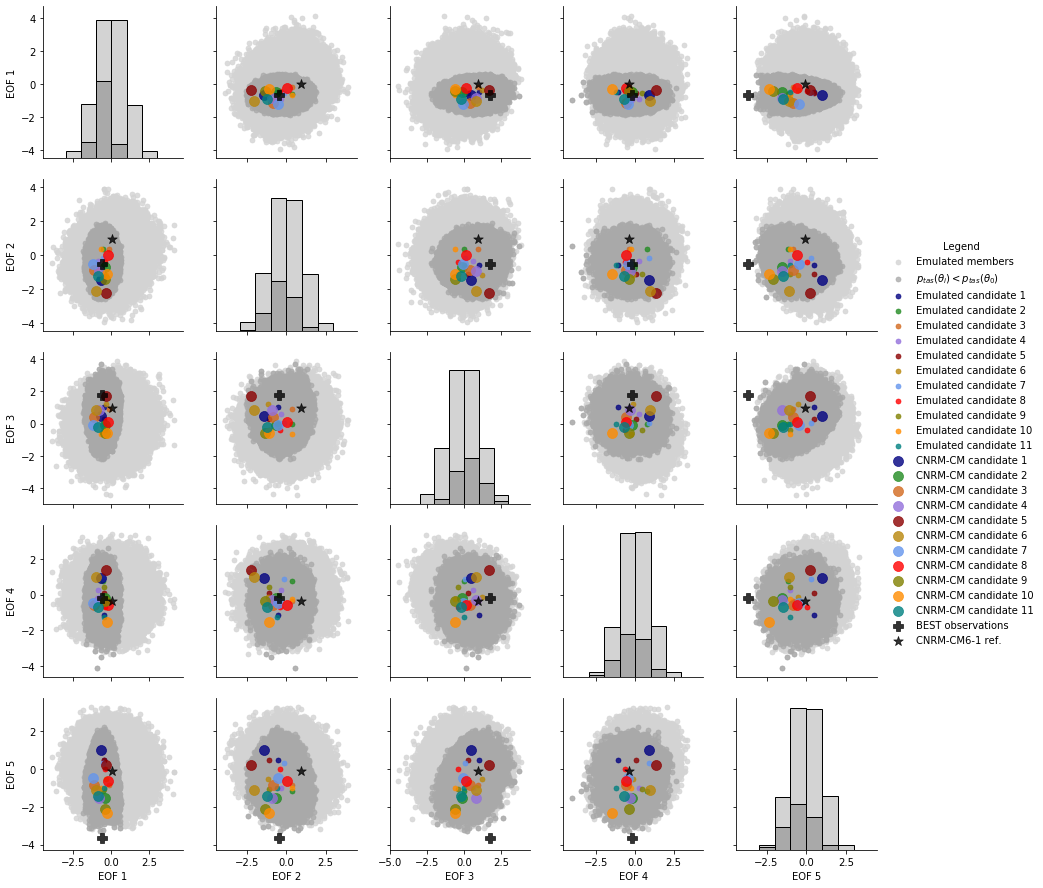

In [47]:
plt.figure()
    
variables = ['EOF 1', 'EOF 2', 'EOF 3', 'EOF 4', 'EOF 5']
p = ['lightgray',  'darkgray',
     'navy', 'forestgreen', 'chocolate', 'mediumpurple', 'darkred', 'darkgoldenrod',
     'cornflowerblue', 'red', 'olive', 'darkorange', 'teal',
     'navy', 'forestgreen', 'chocolate', 'mediumpurple', 'darkred', 'darkgoldenrod',
    'cornflowerblue', 'red', 'olive','darkorange', 'teal', 
    'black', 'black', ]
m = ['.','.',
     '.','.','.','.','.','.','.','.','.','.','.',
     'o','o','o','o','o','o','o','o','o','o','o',
    'P','*']
n = [-4,-3,-2,-1,0,1,2,3,4]

sns.pairplot(df_fig, vars=variables, hue="Legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None , s=100, alpha=0.8), 
             diag_kws=dict(edgecolor='black', bins=n))

#--------------- Save figure ---------------
name_fig='Candidates_tas_EOF_rev_k_medians.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#-------------------------------------------

plt.show()

In [115]:
Names= []
for i in range(1,trunc+1,1) : 
    tmp = 'EOF '+str(i)
    Names.append(tmp)
#Names.append('p')
#Names

## -- Emulated members
df_pc_pred = pd.DataFrame(pc_pred['pcs'][0:trunc].values.transpose(), columns=Names)
df_fig = df_pc_pred.copy()#.reset_index()
df_fig['Legend'] = ['Emulated members']*len(df_fig)
#df_fig

## -- Members with lower error than reference
df_pc_low = df_optim.drop('LHS index', axis=1)
df_pc_low['Legend'] = ['$p_{tas}(\\theta_i)<p_{tas}(\\theta_0)$']*len(df_pc_low)
df_fig = df_fig.append(df_pc_low)
#df_fig

## -- CNRM-CM candidates 
names=[]
for i in range(1,len(nb_p_select)+1,1) :
    tmp = 'CNRM-CM candidates '+str(i)
    names.append(tmp)
df_sel['Legend'] = names 
df_fig = df_fig.append(df_sel)

## -- Observations 
U_obs_list = []
Names = []
cpt=1
cols = []
#cols = ['index']
U_obs_tmp = pc_obs#['pseudo_pcs'].values
U_obs = U_obs_tmp[0:trunc]
for i in U_obs :
    U_obs_list.append(float(i))
    tmp = 'EOF '+str(cpt)
    cols.append(tmp)
    Names.append(tmp)
    cpt+=1
df_obs = pd.DataFrame([U_obs_list], columns=Names)
#df_obs['index'] = 0
df_obs['p'] = 0
df_obs['Legend'] = 'BEST observations'
#cols.append('p')
cols.append('Legend')
df_obs_sort = df_obs[cols]
df_fig = df_fig.append(df_obs_sort)
#df_fig

## -- Reference CNRM-CM6-1
U_p1_list = []
U_p1_tmp = pc_p1.values
U_p1 = U_p1_tmp[0:trunc]
for i in U_p1 : 
    U_p1_list.append(float(i))
df_p1 = pd.DataFrame([U_p1_list], columns=Names)
#df_p1['index'] = 0
#df_p1['p'] = p_p1
df_p1['Legend'] = 'CNRM-CM6-1 ref.'
df_p1_sort = df_p1[cols]
df_fig = df_fig.append(df_p1_sort)
#df_fig

<Figure size 432x288 with 0 Axes>

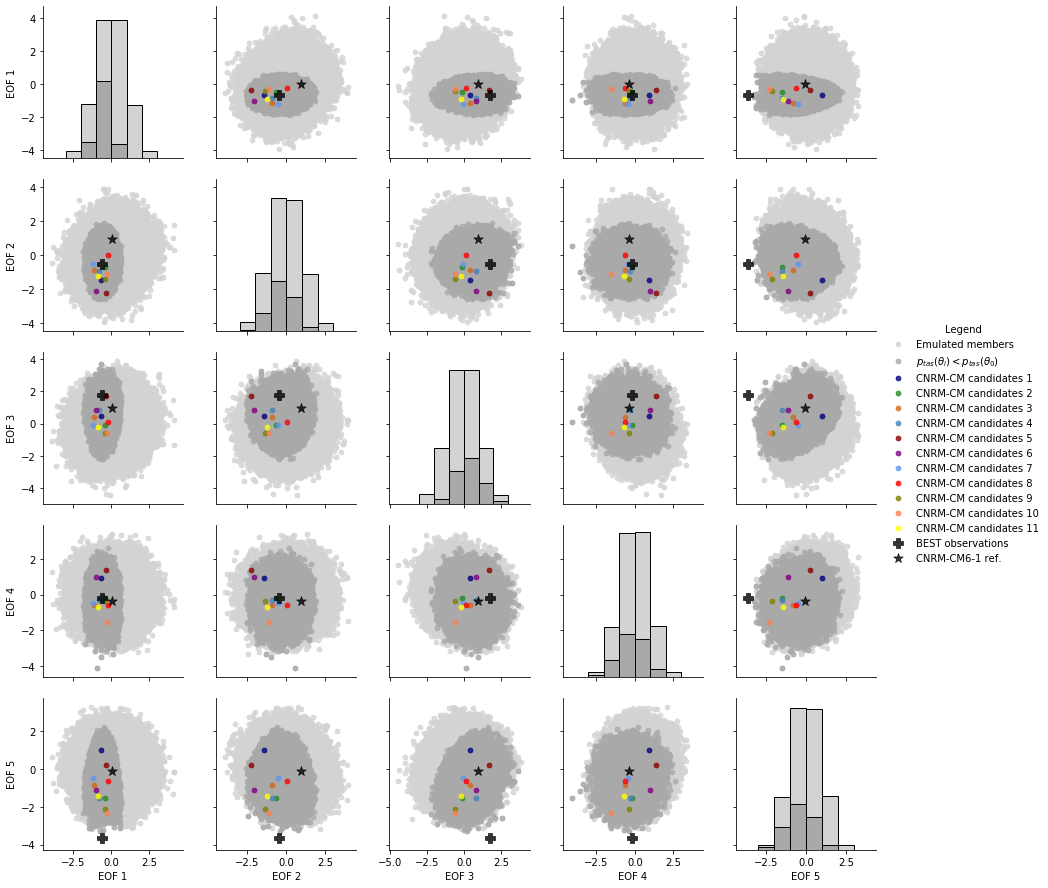

In [117]:
plt.figure()
    
variables = ['EOF 1', 'EOF 2', 'EOF 3', 'EOF 4', 'EOF 5']
p = ['lightgray',  'darkgray',
     'navy', 'forestgreen', 'chocolate', 'steelblue', 'darkred', 'purple',
     'cornflowerblue', 'red', 'olive', 'coral', 'yellow', 'black', 'black']
m = ['.','.',
     '.','.','.','.','.','.','.','.','.','.','.',
    'P','*']
n = [-4,-3,-2,-1,0,1,2,3,4]

sns.pairplot(df_fig, vars=variables, hue="Legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None , s=100, alpha=0.8), 
             diag_kws=dict(edgecolor='black', bins=n))

#--------------- Save figure ---------------
name_fig='Candidates_tas_EOF_rev_k_medians_no_emul.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#-------------------------------------------

plt.show()